In [1]:
# IMPORT DES BIBLIOTHEQUES
import numpy as np
import matplotlib.pyplot as plt
import skimage as ski
import os

c:\Users\louis\Desktop\TELECOM PARIS\2A\IMA\IM01


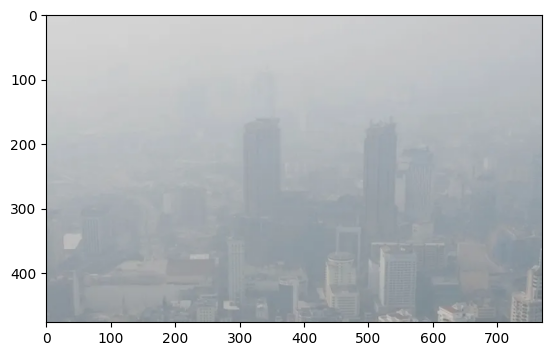

In [2]:
print(os.getcwd())
# os.chdir('Distributed_haze1k/test_thin/input')
# list_img = [ski.io.imread(file) for file in os.listdir()] 
list_img = [ski.io.imread('db8baeb6bf2c4128893311f1b0c7bcbb_9.png')]
image = list_img[0]
plt.imshow(image)

C:\Users\louis\AppData\Local\Temp\ipykernel_17348\668913050.py:23: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  J = ski.morphology.erosion(min_channel, ski.morphology.square(size))


Text(0.5, 1.0, 'Image originale')

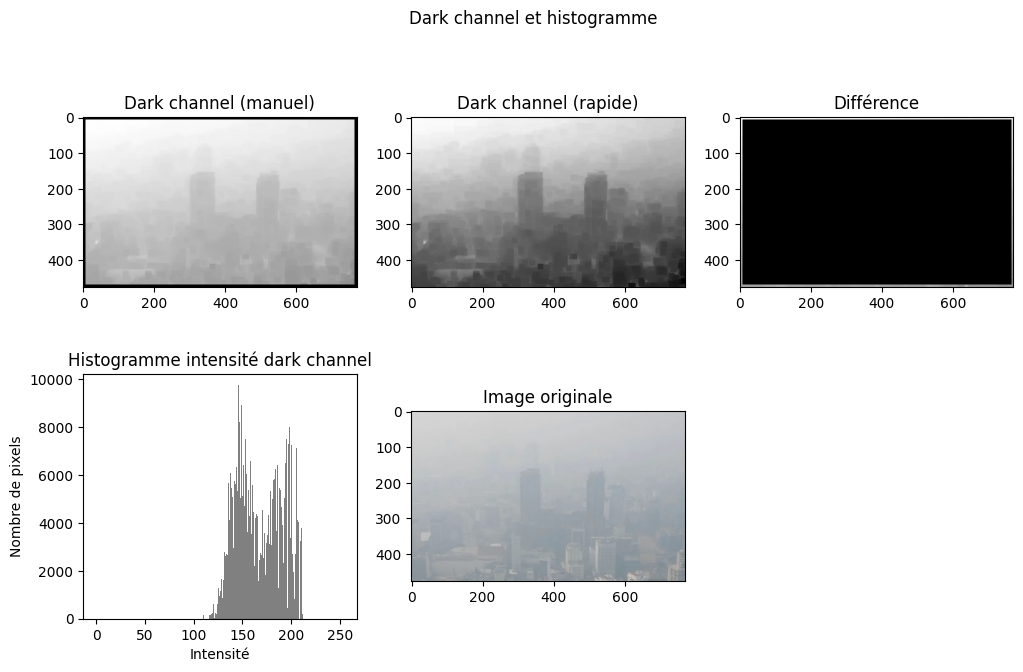

In [3]:
# DARK CHANNEL

size = 15 # taille de la fenêtre

def dark_channel(I, size):
    '''
    Calcul du dark channel manuellement avec des boucles for
    '''
    r,g,b = 255,255,255
    J = np.zeros((I.shape[0], I.shape[1]))
    for i in range(size//2, I.shape[0]-size//2):
        for j in range(size//2, I.shape[1]-size//2):
            r = I[i-size//2:i+size//2+1, j-size//2:j+size//2+1, 0].min()
            g = I[i-size//2:i+size//2+1, j-size//2:j+size//2+1, 1].min()
            b = I[i-size//2:i+size//2+1, j-size//2:j+size//2+1, 2].min()
            J[i,j] = min(r,g,b)
    return J

Jdark = dark_channel(image, size)

def dark_channel_fast(I, size):
    min_channel = np.min(I, axis=2) # minimum sur les 3 canaux pour chaque pixel
    J = ski.morphology.erosion(min_channel, ski.morphology.square(size))
    return J

Jdark_1 = dark_channel_fast(image, size)

fig = plt.figure(figsize=(12, 7))
fig.suptitle("Dark channel et histogramme")
plt.subplot(2, 3, 1)
plt.imshow(Jdark, cmap='gray')
plt.title('Dark channel (manuel)')
plt.subplot(2, 3, 2)
plt.imshow(Jdark_1, cmap='gray')
plt.title('Dark channel (rapide)')
plt.subplot(2,3,3)
plt.imshow(abs(Jdark - Jdark_1), cmap='gray')
plt.title('Différence')

# Calcul de l'histogramme du dark channel rapide
Jdark_1_int = np.clip(Jdark_1, 0, 255).astype(np.uint8)
hist, bins = np.histogram(Jdark_1_int, bins=256, range=(0,255))

plt.subplot(2,3,4)
plt.bar(bins[:-1], hist, width=1, color='gray')
plt.title('Histogramme intensité dark channel')
plt.xlabel('Intensité')
plt.ylabel('Nombre de pixels')

# Affichage image originale
plt.subplot(2,3,5)
plt.imshow(image)
plt.title('Image originale')

C:\Users\louis\AppData\Local\Temp\ipykernel_17348\668913050.py:23: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  J = ski.morphology.erosion(min_channel, ski.morphology.square(size))


Transmission estimée avec le max


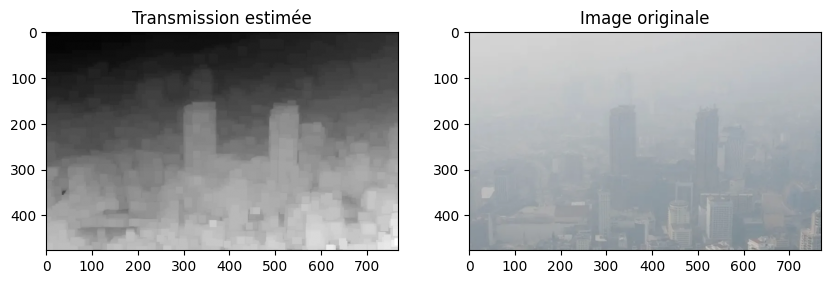

In [4]:
# ESTIMATION DE TRANSMISSION (MAXIMUM DU DARK CHANNEL)
w = 0.95 

def T(I,Jdark, size):
    '''
    Calcul du  manuellement avec des boucles for
    '''
    r,g,b = 255,255,255
    A = np.max(Jdark)
    T = 1- w*dark_channel_fast(I/A, size)
    return T

T1 = T(image, Jdark_1, size)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Transmission estimée")
plt.imshow(T1, cmap='gray')
plt.subplot(1, 2, 2)
plt.title("Image originale")
plt.imshow(image)
print("Transmission estimée avec le max")




C:\Users\louis\AppData\Local\Temp\ipykernel_17348\668913050.py:23: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  J = ski.morphology.erosion(min_channel, ski.morphology.square(size))


Transmission estimée avec le 0.1%


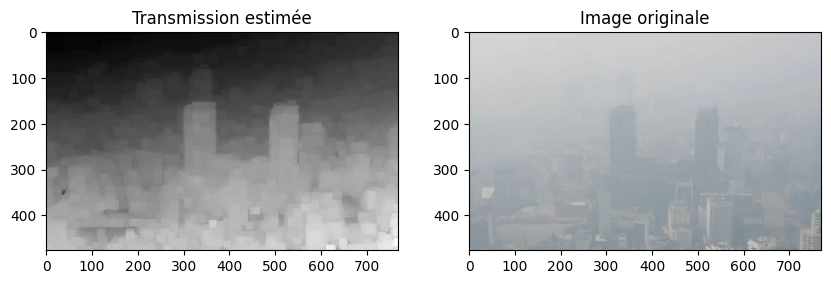

In [5]:
# ESTIMATION DE TRANSMISSION (0.1% DU DARK CHANNEL)
w = 0.95 # paramètre de réglage

def T(I,Jdark, size):
    '''
    Calcul du  manuellement avec des boucles for
    '''
    r,g,b = 255,255,255
    Ac = np.percentile(Jdark, 99.9)
    T = 1- w*dark_channel_fast(I/Ac, size)
    return T

T2 = T(image, Jdark_1, size)
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.title("Transmission estimée")
plt.imshow(T2, cmap='gray')
plt.subplot(1, 2, 2)
plt.title("Image originale")
plt.imshow(image)
print("Transmission estimée avec le 0.1%")

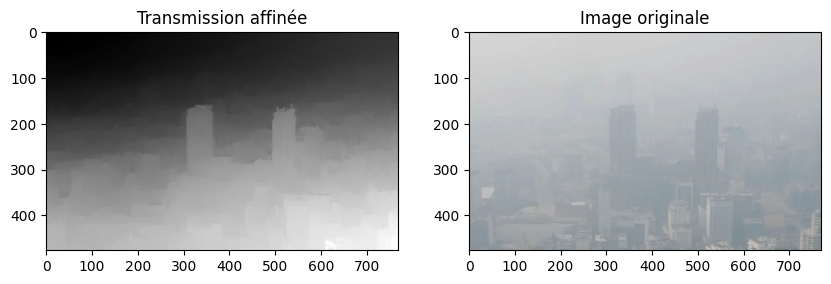

In [6]:
# Calcul complet de la transmission affinée avec Laplacienne

from skimage.util import view_as_windows
from scipy.sparse import coo_matrix, eye
from scipy.sparse.linalg import spsolve

l = 1e-4
plt.close('all')
def matting_laplacian_vectorized(im, eps=1e-5, win_size=3):
    h, w, c = im.shape
    N = h * w
    idx_map = np.arange(N).reshape(h, w)

    # Extraire tous les patchs et leurs indices
    patch_pixels = view_as_windows(im, (win_size, win_size, c))
    num_patches = patch_pixels.shape[0] * patch_pixels.shape[1]
    patch_pixels = patch_pixels.reshape(num_patches, win_size*win_size, c)

    patch_indices = view_as_windows(idx_map, (win_size, win_size))
    patch_indices = patch_indices.reshape(num_patches, win_size*win_size)

    row = []
    col = []
    data = []

    for patch, indices in zip(patch_pixels, patch_indices):
        m = win_size*win_size
        mu = np.mean(patch, axis=0, keepdims=True)  # moyenne 1x3
        diff = patch - mu                             # mx3
        Sigma = diff.T @ diff / m + (eps/m) * np.eye(c)  # 3x3
        Sigma_inv = np.linalg.inv(Sigma)
        
        # Calculer la matrice locale du patch en une seule opération
        vals = np.eye(m) - (1 + diff @ Sigma_inv @ diff.T) / m
        
        # Ajouter les indices et valeurs pour la matrice sparse
        ii, jj = np.meshgrid(indices, indices, indexing='ij')
        row.append(ii.ravel())
        col.append(jj.ravel())
        data.append(vals.ravel())

    # Concaténer toutes les contributions
    row = np.concatenate(row)
    col = np.concatenate(col)
    data = np.concatenate(data)

    L = coo_matrix((data, (row, col)), shape=(N, N)).tocsr()
    return L

image_normalize = image.astype(np.float64) / 255.0
h, w, c = image_normalize.shape
N = h * w
L = matting_laplacian_vectorized(image_normalize)
A = L + l * eye(N, format='csr')
b = l * T2.flatten()
T_refined = spsolve(A, b)
T_refined = T_refined.reshape(h, w)

# Affichage
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.title("Transmission affinée")
plt.imshow(T_refined, cmap='gray')
plt.subplot(1, 2, 2)
plt.title("Image originale")
plt.imshow(image)

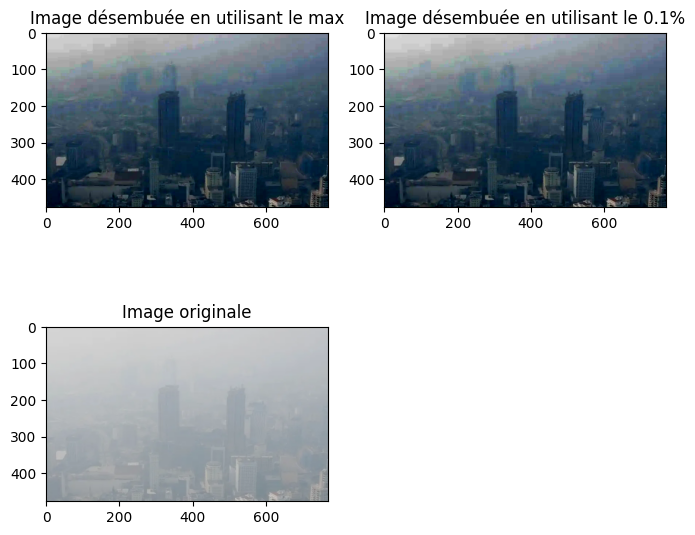

In [7]:
# Correction du calcul de A et Ac pour gérer n'importe quel nombre de canaux
A = np.array([np.max(Jdark)] * image.shape[2]) if image.ndim == 3 else np.max(Jdark)
Ac = np.array([np.percentile(Jdark, 99.9)] * image.shape[2]) if image.ndim == 3 else np.percentile(Jdark, 99.9)
T_clip = np.clip(T_refined, 0.1, 1)

# On s'assure que A et Ac ont la bonne forme pour le broadcasting
A = A.reshape((1,1,-1)) if isinstance(A, np.ndarray) and A.ndim == 1 else A
Ac = Ac.reshape((1,1,-1)) if isinstance(Ac, np.ndarray) and Ac.ndim == 1 else Ac

J = (image.astype(np.float64) - A) / T_clip[..., None] + A
J1 = (image.astype(np.float64) - Ac) / T_clip[..., None] + Ac

plt.figure(figsize=(8, 7))
plt.subplot(2, 2, 1)
plt.title("Image désembuée en utilisant le max")
plt.imshow(np.clip(J, 0, 255).astype(np.uint8))
plt.subplot(2, 2, 2)
plt.title("Image désembuée en utilisant le 0.1%")
plt.imshow(np.clip(J1, 0, 255).astype(np.uint8))
plt.subplot(2, 2, 3)
plt.title("Image originale")
plt.imshow(image)
# plt.subplot(2, 2, 4)
# plt.title("Vraie image")
# os.chdir('../target')
# real = ski.io.imread(os.listdir()[0])
# plt.imshow(real)

Text(0.5, 1.0, 'Carte de profondeur estimée')

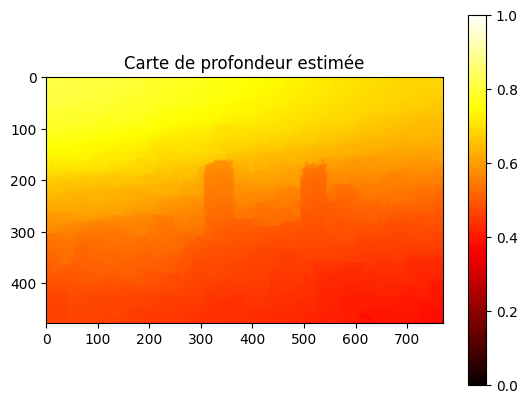

In [16]:
D = -np.log(T_clip) / 2.5
plt.imshow(D, cmap='hot', vmin=0, vmax=1)
plt.colorbar()
plt.title("Carte de profondeur estimée")


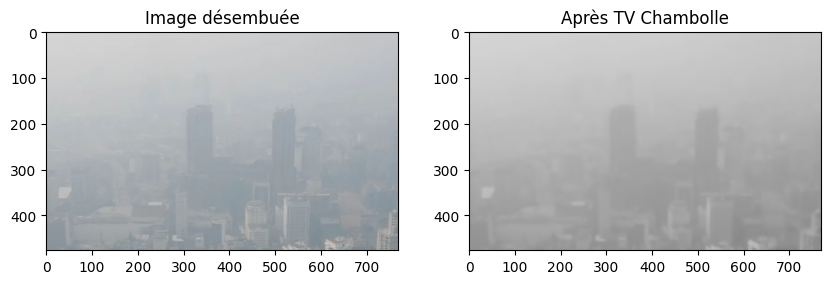

In [9]:
from skimage.restoration import denoise_tv_chambolle

# J doit être en float dans [0,1] pour tv_chambolle
J_float = np.clip(image / 255.0, 0, 1)
J_tv = denoise_tv_chambolle(J_float, weight=0.1)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Image désembuée")
plt.imshow(J_float)
plt.subplot(1, 2, 2)
plt.title("Après TV Chambolle")
plt.imshow(J_tv)